In [1]:
# import importlib
# importlib.reload(cluster_util)
# import cluster_util

# Notebook error analysis 

## Refining error types - Evaluate cluster results


clusters and LDA 

LDA, Latent Dirichlet Allocation

    LDA works off the premise that documents with the same topic will have a lot of words in common.
    LDA is a bag of words model meaning that it only considers individual tokens and not their relationships in a sentence.

In [1]:
# clustered results

import pandas as pd 
import cluster_util, config

df_mlerr_clustered = pd.read_excel(config.path_default.joinpath("df_mlerr_mlbugs_pregroup_dedup_clustered.xlsx"))

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


hierarchical clustering tree -> labels

In [41]:
import pickle

with open(config.path_default.joinpath("aggroot_transformer.pkl"), "rb") as f:
    root_sentence = pickle.load(f)

In [42]:
import pickle

with open(config.path_default.joinpath("aggroot_wordemb.pkl"), "rb") as f:
    root_word = pickle.load(f)
# root_word = cluster_util.aggcluster_to_tree(model_load)

In [43]:
# function for labeling data with predefined num of clusters
from bigtree import levelorder_iter,levelordergroup_iter
import numpy as np

def hc_tree_labeling(root_node, n_clusters):
    res_labels = np.zeros(len(list(root_node.leaves)))
    for group in levelordergroup_iter(root_node):
    #     print(len(list(group)))
        if len(list(group)) >= n_clusters:
            id_clusters = 1
            for node_sib in group:
                if id_clusters < n_clusters:
                    for leaf in node_sib.leaves:
                        res_labels[leaf.node_name-1] = id_clusters
                    id_clusters += 1
                else:
                    for leaf in node_sib.leaves:
                        res_labels[leaf.node_name-1] = id_clusters
            break
    return res_labels

df_mlerr_clustered.loc[:,"cluster_hc_transformers"] = hc_tree_labeling(root_sentence, n_clusters=60)
df_mlerr_clustered.loc[:,"cluster_hc_wordemb"] = hc_tree_labeling(root_word, n_clusters=60)

In [ ]:
# # explore hc tree based on node sizes

# from bigtree import levelorder_iter

# res_nodes = []

# for node in levelorder_iter(root):
#     if len(list(node.leaves)) in range(20,60):
#         res_nodes.append(node)

        
# import random
# #take the last one for example
# res_names = [leave_node.node_name-1 for leave_node in res_nodes[random.randint(0,len(res_nodes))].leaves]
# # see what are they
# for i in df_mlerr_mlbugs_unique.iloc[res_names].evalue:
#     print("==>",i)
    
# df_mlerr_mlbugs_unique.iloc[res_names]

kmeans, dbscan, optics with document-level(sentence transformer) and word-level(finetuned subword-wordemb) embeddings

LDA60+75

H-clustering60+75

In [76]:
df_mlerr_clustered.columns

Index(['fname', 'eid', 'ename', 'evalue', 'traceback', 'ename_mapped',
       'imports', 'lib_alias', 'exp_mllib', 'exp_mllib_extracted',
       'python_version', 'evalue_tokenized', 'hash_evalue_tokenized',
       'cluster_km_transformers', 'cluster_dbscan_transformers',
       'cluster_optics_transformers', 'cluster_km_glove',
       'cluster_dbscan_glove', 'cluster_optics_glove', 'cluster_lda60',
       'cluster_lda75', 'cluster_km_wordemb', 'cluster_dbscan_wordemb',
       'cluster_optics_wordemb', 'cluster_hc_wordemb',
       'cluster_hc_transformers'],
      dtype='object')

evaluate if the clusterings correlate

In [130]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(df_mlerr_clustered.cluster_km_transformers, df_mlerr_clustered.cluster_km_wordemb)

0.20138148164723754

In [48]:
adjusted_rand_score(df_mlerr_clustered.cluster_dbscan_transformers, df_mlerr_clustered.cluster_dbscan_wordemb)

0.023854138369017626

In [50]:
adjusted_rand_score(df_mlerr_clustered.cluster_optics_transformers, df_mlerr_clustered.cluster_optics_wordemb)

0.30616859771333393

In [54]:
adjusted_rand_score(df_mlerr_clustered.cluster_hc_transformers, df_mlerr_clustered.cluster_hc_wordemb)

0.04210359137590884

In [132]:
adjusted_rand_score(df_mlerr_clustered.cluster_optics_transformers, df_mlerr_clustered.cluster_lda60)

0.015375541834677965

In [133]:
adjusted_rand_score(df_mlerr_clustered.cluster_optics_wordemb, df_mlerr_clustered.cluster_lda60)

0.10503195313545205

In [75]:
adjusted_rand_score(df_mlerr_clustered.cluster_hc_transformers, df_mlerr_clustered.cluster_lda60)

0.0604557538916081

In [73]:
adjusted_rand_score(df_mlerr_clustered.cluster_dbscan_wordemb, df_mlerr_clustered.cluster_lda60)

0.41332208941227294

In [71]:
adjusted_rand_score(df_mlerr_clustered.cluster_km_wordemb, df_mlerr_clustered.cluster_lda60)

0.21927502871512328

We implemented and tried quite a lot of alternative embeddings and clustering algorithms. We focus on:

    embeddings:
        document level embedding -> sentence transformer
        word level embedding -> finetuned word embedding with fasttext (support subword)
    clustering:
        kmeans
        (maybe shold exclude, too many noise samples)dbscan/optics
        hc
        lda
Evaluate clusters:

    take a random subset (say 200 errors), take each pair, manually label -> if they should be in the same cluster or not
    check clustering results based on the labeling
    then choose a reasonable embedding+clustering technique
ML bug categorization:

    with the chosen embedding+clustering results, summarize each clusters and assign them to existing or new categories

In [86]:
# random sample pairs

import random

# all pairs
id_pairs = []
for i in df_mlerr_clustered.index:
    for j in range(i+1, len(df_mlerr_clustered.index)):
        id_pairs.append((i, j))
print(len(id_pairs))

# random sample
n = 200
sampled_pair_ids = random.sample(id_pairs, n)

# get dataframes
sampled_pair_id_left = [p[0] for p in sampled_pair_ids]
sampled_pair_id_right = [p[1] for p in sampled_pair_ids]

df_mlerr_sample_left = df_mlerr_clustered.loc[sampled_pair_id_left,:]
df_mlerr_sample_right = df_mlerr_clustered.loc[sampled_pair_id_right,:]

# save the sampled dataframes
df_mlerr_sample_left.to_excel(config.path_default.joinpath("df_mlerr_clustered_sample_left.xlsx"),
                              index=False, engine='xlsxwriter')
df_mlerr_sample_right.to_excel(config.path_default.joinpath("df_mlerr_clustered_sample_right.xlsx"),
                               index=False, engine='xlsxwriter')

105378903

In [107]:
# gather results from clustering algorithms

check_columns = ['cluster_km_transformers', 'cluster_dbscan_transformers',
                 'cluster_optics_transformers', 'cluster_km_glove',
                 'cluster_dbscan_glove', 'cluster_optics_glove', 'cluster_lda60',
                 'cluster_lda75', 'cluster_km_wordemb', 'cluster_dbscan_wordemb',
                 'cluster_optics_wordemb', 'cluster_hc_wordemb','cluster_hc_transformers']
res = {} # same:1, not same:0
for cn in check_columns:
    res[cn] = np.full(n, -1)
    for i in range(n):
        res[cn][i] = df_mlerr_sample_left.iloc[i][cn]==df_mlerr_sample_right.iloc[i][cn]
        
df_res_mlerr_sample = pd.DataFrame.from_dict(res)
df_res_mlerr_sample.loc[:, "fname_left"] = df_mlerr_sample_left.fname.reset_index(drop=True)
df_res_mlerr_sample.loc[:, "eid_left"] = df_mlerr_sample_left.eid.reset_index(drop=True)
df_res_mlerr_sample.loc[:, "fname_right"] = df_mlerr_sample_right.fname.reset_index(drop=True)
df_res_mlerr_sample.loc[:, "eid_right"] = df_mlerr_sample_right.eid.reset_index(drop=True)
df_res_mlerr_sample.to_excel(config.path_default.joinpath("df_mlerr_clustered_sample_res_algrithms.xlsx"),
                             index=False, engine='xlsxwriter')

### Compare with manual results

Potential clusters:

    Tensor shape mismatch
    Wrong understanding of data (column not found, wrong key)
    Wrongly use APIs (wrong inputs, miss arguments)
    Wrong attribute to object
    Logic error (undefined, wrong operations-bool+[])
    External errors (no file found, )
    
manual labeling [file](https://liuonline-my.sharepoint.com/:x:/r/personal/yirwa29_liu_se/_layouts/15/Doc.aspx?sourcedoc=%7BA108BDF6-8E26-4B44-BF4F-68E4FBF689C5%7D&file=df_mlerr_clustered_sample_res_manual.xlsx&action=default&mobileredirect=true)

In [ ]:
# sampled clustered results

import pandas as pd 
import cluster_util, config

df_res_mlerr_sample = pd.read_excel(config.path_default.joinpath("df_mlerr_clustered_sample_res_algrithms.xlsx"))

# Join back the original dataset (before pregroup/dedup)

In [101]:
import pandas as pd 
import config

df_mlerr_dedup_clustered = pd.read_excel(config.path_default.joinpath("df_mlerr_mlbugs_filtered_dedup_clustered.xlsx"))

df_mlerr_k = pd.read_excel(config.path_kaggle_error_analysis.joinpath('df_mlerr_k_mlbugs_filtered.xlsx'))
df_mlerr_g = pd.read_excel(config.path_github_error_analysis.joinpath('df_mlerr_g_mlbugs_filtered.xlsx'))
df_mlerr = pd.concat([df_mlerr_g, df_mlerr_k], ignore_index=True, sort=False)

In [64]:
# handle noise means that all noise(-1) are in their own clusters(-2,-2-noise samples)
def assign_clusterres_to_wholedata(df_dedup_clustered, df_mlerr, key = "cluster_optics_transformers", if_handle_noise = True):
    noise_label = -2
    for index,row in df_dedup_clustered.iterrows():
        if row[key] == -1:
            res_label = noise_label
        else:
            res_label = row[key]
        hv_tmp = df_mlerr.loc[df_mlerr.eid==row.eid, "hash_evalue_tokenized"]
        if len(hv_tmp)>1:
            print("error: more than one hash value found. eid:", row.eid)
        elif len(hv_tmp)==1:
            hv = hv_tmp.iloc[0]
            df_mlerr.loc[df_mlerr.hash_evalue_tokenized==hv,key] = res_label
            noise_label -= 1

In [102]:
key_cluster_res = "cluster_optics_transformers"
assign_clusterres_to_wholedata(df_mlerr_dedup_clustered, df_mlerr, key = key_cluster_res)

In [103]:
df_mlerr_cluster_size = df_mlerr.groupby("cluster_optics_transformers").size().sort_values(ascending=False)
df_mlerr_cluster_size

cluster_optics_transformers
 1276.0     1214
 154.0       806
 784.0       550
 1890.0      504
 1510.0      408
            ... 
-3385.0        1
-3386.0        1
-3387.0        1
-7984.0        1
-14511.0       1
Length: 10438, dtype: int64

In [ ]:
# key errors tend to be only one word/the key(e.g., 'val_accuracy) in error values? 
# this will be excluded when pregrouping. preprocess_text_similarity() will delete words inside ''
# df_mlerr_mlbugs[df_mlerr_mlbugs.ename=="keyerror"].evalue

<Axes: xlabel='cluster_optics_transformers'>

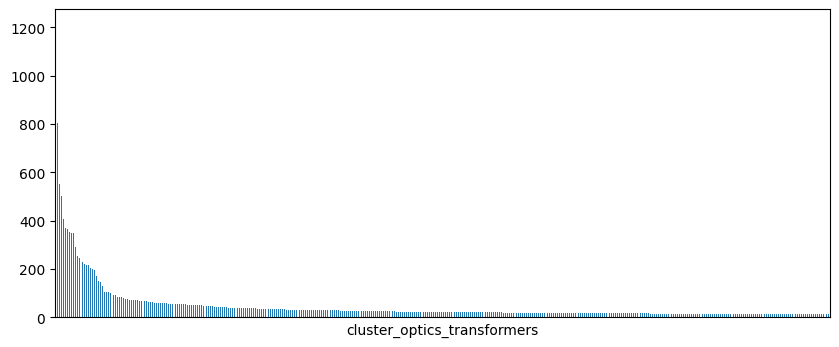

In [127]:
df_mlerr_cluster_size.iloc[:400].plot(kind="bar", xticks=[], figsize=(10,4))

In [113]:
print((df_mlerr_cluster_size.cumsum()/df_mlerr.eid.nunique()).searchsorted(0.7)) # num of clusters needed for cover certain percent of errors

cutoff_cluster_size = 5
print(sum(df_mlerr_cluster_size>=cutoff_cluster_size)) # num of clusters needed for cluster size over ceratin number
print(sum(df_mlerr_cluster_size[df_mlerr_cluster_size>=cutoff_cluster_size])/df_mlerr.eid.nunique()) # percentage

1760
1706
0.6957881945342193


if looking at kaggle and github separately

In [65]:
key_cluster_res = "cluster_optics_transformers"
assign_clusterres_to_wholedata(df_mlerr_dedup_clustered, df_mlerr_k, key = key_cluster_res)
assign_clusterres_to_wholedata(df_mlerr_dedup_clustered, df_mlerr_g, key = key_cluster_res)

kaggle

In [70]:
df_mlerr_k_cluster_size = df_mlerr_k.groupby("cluster_optics_transformers").size().sort_values(ascending=False)

In [72]:
df_mlerr_k_cluster_size

cluster_optics_transformers
 1276.0    84
 1359.0    53
 154.0     39
 1890.0    36
 141.0     27
           ..
-63.0       1
-58.0       1
-53.0       1
-52.0       1
 2498.0     1
Length: 1258, dtype: int64

<Axes: xlabel='cluster_optics_transformers'>

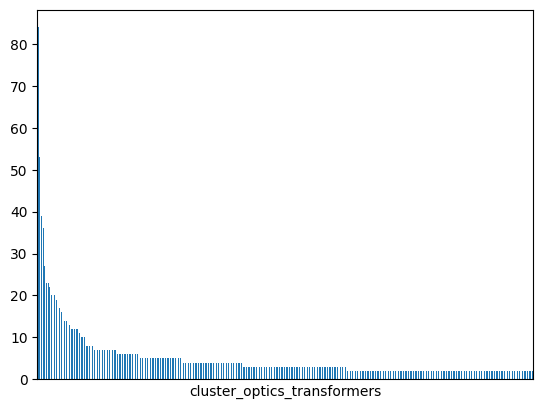

In [123]:
df_mlerr_k_cluster_size.iloc[:300].plot(kind="bar", xticks=[])

In [105]:
print((df_mlerr_k_cluster_size.cumsum()/df_mlerr_k.eid.nunique()).searchsorted(0.7))

cutoff_cluster_size = 2
print(sum(df_mlerr_k_cluster_size>=cutoff_cluster_size)) # num of clusters
print(sum(df_mlerr_k_cluster_size[df_mlerr_k_cluster_size>=cutoff_cluster_size])/df_mlerr_k.eid.nunique()) # percentage

496
365
0.6481481481481481


github

In [81]:
df_mlerr_g_cluster_size = df_mlerr_g.groupby("cluster_optics_transformers").size().sort_values(ascending=False)
df_mlerr_g_cluster_size

cluster_optics_transformers
 1276.0    1130
 1777.0     769
 784.0      538
 1890.0     468
 1510.0     392
           ... 
-3163.0       1
-3164.0       1
-3170.0       1
-3171.0       1
-4108.0       1
Length: 9966, dtype: int64

<Axes: xlabel='cluster_optics_transformers'>

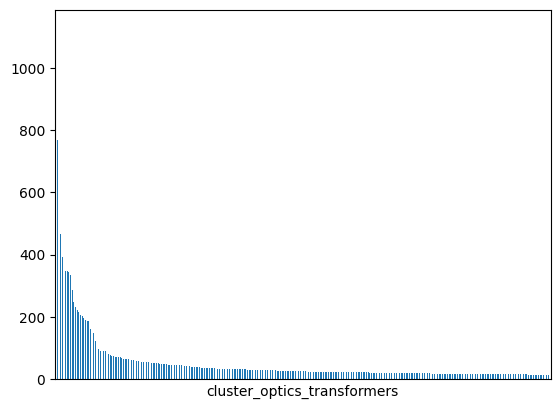

In [122]:
df_mlerr_g_cluster_size.iloc[:300].plot(kind="bar", xticks=[])

In [83]:
(df_mlerr_g_cluster_size.cumsum()/df_mlerr_g.eid.nunique()).searchsorted(0.7)

1712

In [95]:
cutoff_cluster_size = 5
print(sum(df_mlerr_g_cluster_size>=cutoff_cluster_size)) # num of clusters
print(sum(df_mlerr_g_cluster_size[df_mlerr_g_cluster_size>=cutoff_cluster_size])/df_mlerr_g.eid.nunique()) # percentage

1202
0.6468081573922909
